# ***PyMC1 - Final Project - Applied Statistics***

**Omer Shadmi (327722575) & Inbar Fabian (328274212)**

------------

## <u>Getting Started:</u>

The **KING** of this notebook (and the next one) is the **Bayes Formula**:

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

Using this formula we can calculate the probability of an event based on prior knowledge.

We will use PyMC to model the data.

We will use a dataset of NBA games to model the data. We are interested in the probability of a game having a high score (more than 220 points), and how this probability changes over the years.

But first, let's import the libraries we will use:


In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import graphviz

In [60]:
df = pd.read_csv('games.csv')

df.head()

,seasonStartYear,awayTeam,pointsAway,homeTeam,pointsHome,attendance,notes,startET,datetime,isRegular,game_id
0,1996,Sacramento Kings,85,Houston Rockets,96,16285.0,NaN,NaN,1996-11-01,1,1
1,1996,Los Angeles Clippers,97,Golden State Warriors,85,15593.0,NaN,NaN,1996-11-01,1,2
2,1996,Portland Trail Blazers,114,Vancouver Grizzlies,85,19193.0,NaN,NaN,1996-11-01,1,3
3,1996,Seattle SuperSonics,91,Utah Jazz,99,19911.0,NaN,NaN,1996-11-01,1,4
4,1996,New York Knicks,107,Toronto Raptors,99,28457.0,NaN,NaN,1996-11-01,1,5


We will filter the data for the year 2019 and create a binary column for games scoring more than 220 points.


In [61]:
points_data_2019 = df[df['seasonStartYear'] == 2019].copy()  # Filter for 2019
points_data_2019['totalPoints'] = points_data_2019['pointsAway'] + points_data_2019['pointsHome']  # Calculate total points
points_data_2019 = points_data_2019[['totalPoints']].reset_index(drop=True)  # Keep only the 'totalPoints' column and reset index

points_data_2019.head()

,totalPoints
0,252
1,214
2,195
3,208
4,231


In [62]:
points_data_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   totalPoints  1143 non-null   int64
dtypes: int64(1)
memory usage: 9.1 KB


In [63]:
# Create a binary column for games scoring more than 220 points
points_data_2019['high_score'] = points_data_2019['totalPoints'] > 220  
points_data_2019['high_score'] = points_data_2019['high_score'].astype(int)

And this is how this data looks like:


In [64]:
points_data_2019.head()

,totalPoints,high_score
0,252,1
1,214,0
2,195,0
3,208,0
4,231,1


-------------

## <u>Modeling Big Data with PyMC:</u>

Now, It's time to introduce PyMC!


In [65]:
import warnings
warnings.filterwarnings("ignore")

import pymc as pm
import arviz as az

Let's build our first model:


In [66]:
with pm.Model() as model_2019:
    # Define priors
    p = pm.Beta('p', alpha=1, beta=1)  # Prior for the probability of scoring more than 220 points
    
    # Specify the likelihood
    y = pm.Bernoulli('y', p=p, observed=points_data_2019['high_score'])
    
    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 109 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


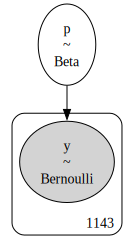

In [67]:
pm.model_to_graphviz(model_2019)

We've used a Beta distribution as a prior for the probability of scoring more than 220 points.

This is the Beta distribution for $\alpha = 1, \beta = 1$:

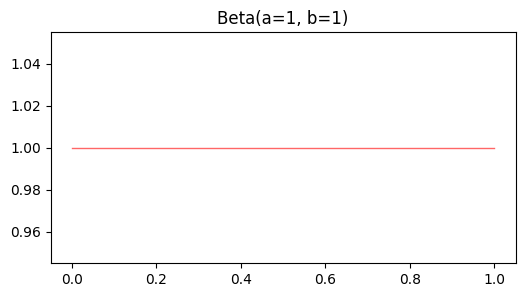

In [68]:
x = np.linspace(0,1, 100)
def plot_beta(a,b):
  plt.plot(x, stats.beta.pdf(x, a, b),'r-', lw=1, alpha=0.6)
  plt.title(f"Beta(a={a}, b={b})")

plt.figure(figsize=(6,3))
plot_beta(1,1)

We want to see the trace of the posterior distribution:


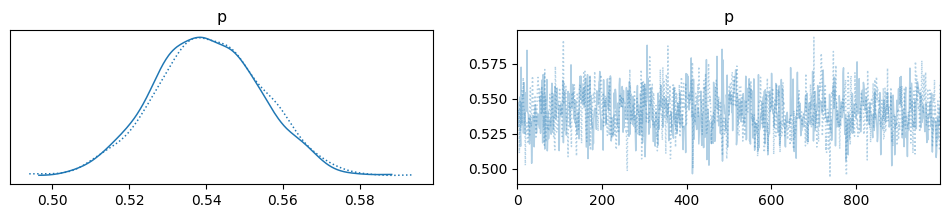

In [69]:
az.plot_trace(trace);

And a summary of the posterior distribution:


In [70]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.541,0.014,0.512,0.568,0.0,0.0,827.0,1440.0,1.0


Let's explain some of the summary statistics:

- **mean**: The mean of our posterior distribution is 0.541. This is the expected value of the probability of scoring more than 220 points.
- **sd**: The standard deviation of our posterior distribution is 0.014. This is the uncertainty of our estimate. As we can see, the uncertainty is very low, which means we are confident in our estimate.
- **hdi_97.5%**: The highest density interval (HDI) is the interval that contains 97.5% of the posterior distribution. This is the range of values that are most likely to contain the true value of the probability of scoring more than 220 points.


Let's plot the posterior distribution:


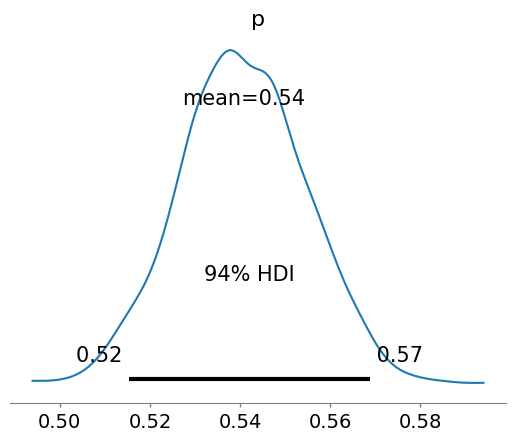

In [71]:
az.plot_posterior(trace);

In the plot above we can see the posterior distribution for the probability of scoring more than 220 points. We can also see the 94% HDI.

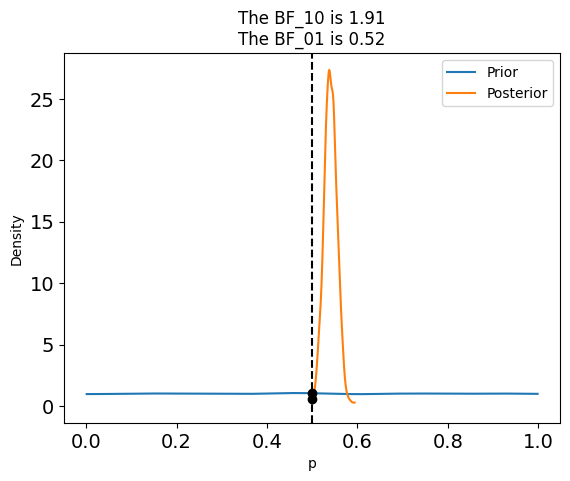

In [72]:
az.plot_bf(trace, var_name="p", prior=np.random.uniform(0, 1, 10_000), ref_val=0.5);

Indeed we can see an evidence that the probability of scoring more than 220 points is higher (or at least different) than 0.5.


Now let's sample from the posterior predictive distribution:


In [73]:
pm.sample_posterior_predictive(trace, model=model_2019, extend_inferencedata=True)

Sampling: [y]


Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

And here we can see the posterior predictive array for the probability of scoring more than 220 points:


In [74]:
trace.posterior_predictive['y']

<xarray.DataArray 'y' (chain: 2, draw: 1000, y_dim_2: 1143)> Size: 18MB
array([[[1, 0, 0, ..., 0, 1, 0],
        [0, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 0, 0, 1],
        ...,
        [1, 1, 1, ..., 1, 0, 1],
        [0, 1, 1, ..., 1, 0, 1],
        [1, 1, 1, ..., 1, 0, 1]],

       [[0, 1, 1, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 1, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [1, 1, 0, ..., 1, 1, 0],
        [1, 0, 1, ..., 1, 0, 1]]], dtype=int64)
Coordinates:
  * chain    (chain) int32 8B 0 1
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * y_dim_2  (y_dim_2) int32 5kB 0 1 2 3 4 5 6 ... 1137 1138 1139 1140 1141 1142

------------

## <u>Modeling Small Data with PyMC:</u>


This time we will use a smaller dataset. We will use a dataset of NBA games from the year 2015. We will sample 50 games from this dataset and model the data using PyMC.


In [75]:
# Filter for the year 2015
data_2015 = df[df['seasonStartYear'] == 2015].copy()

# Create a binary column for games scoring more than 220 points
data_2015['high_score'] = (data_2015['pointsAway'] + data_2015['pointsHome']) > 220
data_2015['high_score'] = data_2015['high_score'].astype(int)

# Randomly sample 50 rows
sampled_data_2015 = data_2015.sample(n=50, random_state=42).reset_index(drop=True)

# Keep only the 'seasonStartYear' and 'high_score' columns
sampled_data_2015 = sampled_data_2015[['seasonStartYear', 'high_score']]

sampled_data_2015.head()

,seasonStartYear,high_score
0,2015,1
1,2015,0
2,2015,1
3,2015,1
4,2015,0


In [76]:
# Prepare the data for modeling
high_scores_2015 = sampled_data_2015['high_score'].values

We are ready to build our model!


In [77]:
# Model the data using PyMC
with pm.Model() as model_2015:
    # Define prior
    p_2015 = pm.Beta('p_2015', alpha=1, beta=1)
    
    # Specify the likelihood
    y_2015 = pm.Bernoulli('y_2015', p=p_2015, observed=high_scores_2015)
    
    # Sample from the posterior
    trace_2015 = pm.sample(1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_2015]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 27 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


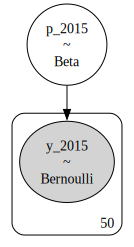

In [78]:
pm.model_to_graphviz(model_2015)

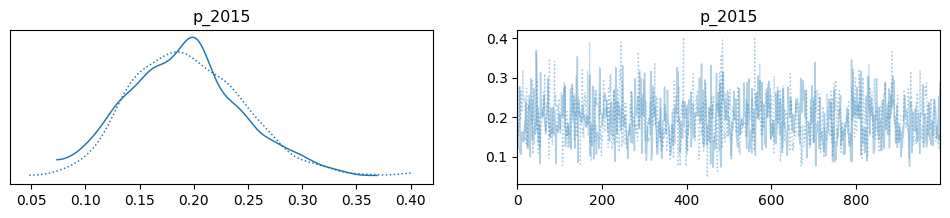

In [79]:
az.plot_trace(trace_2015);

This is the trace for 2015. As we can see, the trace is not as smooth as the one for 2019. This is because we have less data.


In [80]:
az.summary(trace_2015, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_2015,0.194,0.053,0.094,0.3,0.002,0.001,851.0,1353.0,1.0


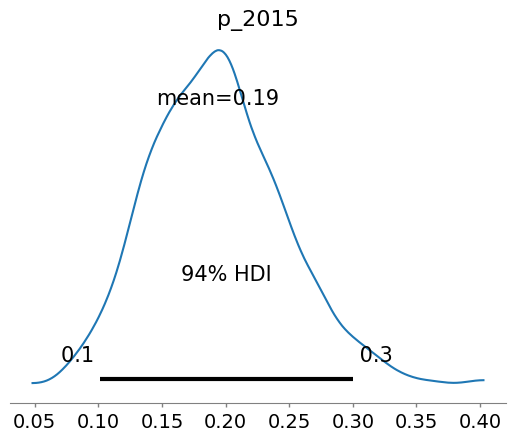

In [81]:
az.plot_posterior(trace_2015);

We can see the 94% HDI for 2015 is wider than the one for 2019. This is because we have less data.


We move to do the same process for 2000.


In [86]:
# Filter for the year 2000
data_2000 = df[df['seasonStartYear'] == 2000].copy()

# Create a binary column for games scoring more than 220 points
data_2000['high_score'] = (data_2000['pointsAway'] + data_2000['pointsHome']) > 220
data_2000['high_score'] = data_2000['high_score'].astype(int)

# Randomly sample 50 rows
sampled_data_2000 = data_2000.sample(n=50, random_state=42).reset_index(drop=True)

# Keep only the 'seasonStartYear' and 'high_score' columns
sampled_data_2000 = sampled_data_2000[['seasonStartYear', 'high_score']]

sampled_data_2000.head()

,seasonStartYear,high_score
0,2000,0
1,2000,0
2,2000,0
3,2000,0
4,2000,0


In [87]:
# Prepare the data for modeling
high_scores_2000 = sampled_data_2000['high_score'].values

# Model the data using PyMC
with pm.Model() as model_2000:
    # Define prior
    p_2000 = pm.Beta('p_2000', alpha=1, beta=1)
    
    # Specify the likelihood
    y_2000 = pm.Bernoulli('y_2000', p=p_2000, observed=high_scores_2000)

    # Sample from the posterior
    trace_2000 = pm.sample(1000, return_inferencedata=True, idata_kwargs={"log_likelihood": True})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_2000]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 39 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


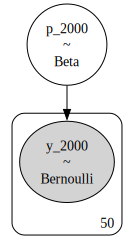

In [88]:
pm.model_to_graphviz(model_2000)

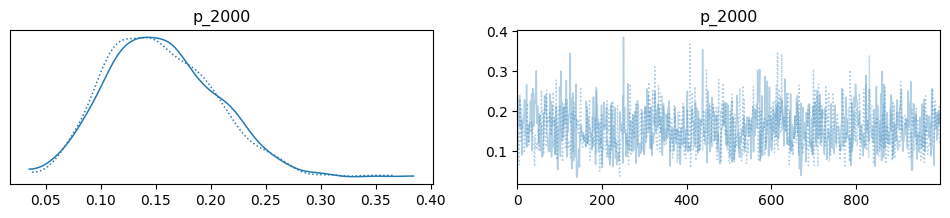

In [89]:
az.plot_trace(trace_2000);

In [90]:
az.summary(trace_2000, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_2000,0.155,0.05,0.064,0.25,0.002,0.001,890.0,1120.0,1.0


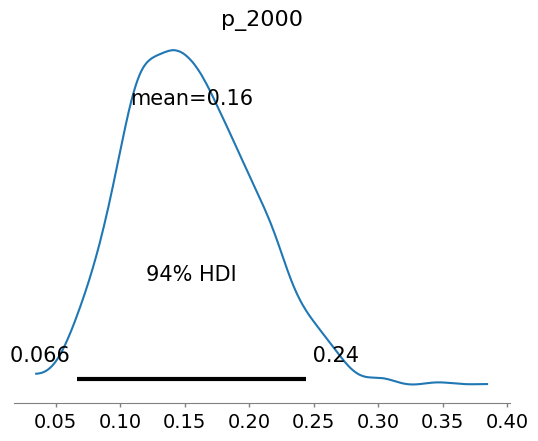

In [91]:
az.plot_posterior(trace_2000);

------------

## <u>Model Comparison:</u>


We will use the Watanabe-Akaike Information Criterion (WAIC) to compare the models.


In [92]:
# Compare the models using WAIC
waic_2000 = az.waic(trace_2000)
waic_2015 = az.waic(trace_2015)

print("WAIC for model_2000:", waic_2000)
print("WAIC for model_2015:", waic_2015)


WAIC for model_2000: Computed from 2000 posterior samples and 50 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -21.24     4.43
p_waic        0.95        -
WAIC for model_2015: Computed from 2000 posterior samples and 50 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -24.52     4.08
p_waic        0.92        -


In [93]:
# Plot the comparison
az.compare({'model_2000': trace_2000, 'model_2015': trace_2015})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_2000,0,-21.249226,0.955733,0.000000,0.643477,4.428927,0.000000,False,log
model_2015,1,-24.527481,0.926712,3.278255,0.356523,4.083497,5.681074,False,log


Hurray! We have a winner!

The model for 2000 is better than the model for 2015.

Now, let's move to the next part of the project.

We will now model the data for the years 1996, 2006, and 2018.

------------------

## <u>Modeling Multiple Years with PyMC:</u>


Now we will model the data for the years 1996, 2006, and 2018. For each year we will sample 300 games, and calculate the probability of scoring more than 220 points.

We're also intrested in seeing if the probability of scoring more than 220 points changes over the years. We already have a guess...


In [ ]:
# Filter for the specified years
years = [1996, 2006, 2018]
filtered_data = df[df['seasonStartYear'].isin(years)].copy()

# Create a binary column for games scoring more than 220 points
filtered_data['high_score'] = (filtered_data['pointsAway'] + filtered_data['pointsHome']) > 220
filtered_data['high_score'] = filtered_data['high_score'].astype(int)

# Randomly sample 300 rows for each year
sampled_data = filtered_data.groupby('seasonStartYear').apply(lambda x: x.sample(n=300, random_state=42)).reset_index(drop=True)

# Keep only the 'high_score' and 'seasonStartYear' columns
sampled_data = sampled_data[['high_score', 'seasonStartYear']]

# Check the shape of the sampled data
print(sampled_data.shape)

(900, 2)


In [ ]:
sampled_data

,high_score,seasonStartYear
0,0,1996
1,0,1996
2,0,1996
3,0,1996
4,0,1996
...,...,...
895,1,2018
896,1,2018
897,0,2018
898,0,2018


In [ ]:
# Prepare the data for modeling
high_scores = sampled_data['high_score'].values
years = sampled_data['seasonStartYear'].values

Modeling the data for the years 1996, 2006, and 2018:


In [ ]:
# Model the data using PyMC
with pm.Model() as model_years:
    # Define priors
    p_1996 = pm.Beta('p_1996', alpha=1, beta=1)
    p_2006 = pm.Beta('p_2006', alpha=1, beta=1)
    p_2018 = pm.Beta('p_2018', alpha=1, beta=1)
    
    # Specify the likelihood
    y_1996 = pm.Bernoulli('y_1996', p=p_1996, observed=high_scores[years == 1996])
    y_2006 = pm.Bernoulli('y_2006', p=p_2006, observed=high_scores[years == 2006])
    y_2018 = pm.Bernoulli('y_2018', p=p_2018, observed=high_scores[years == 2018])
    
    # Sample from the posterior
    trace_years = pm.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_1996, p_2006, p_2018]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 149 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


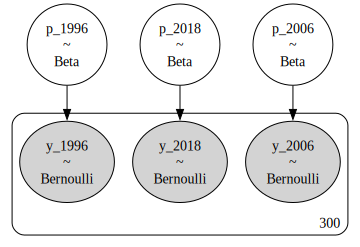

In [ ]:
pm.model_to_graphviz(model_years)

We can see the trace for the years 1996, 2006, and 2018:


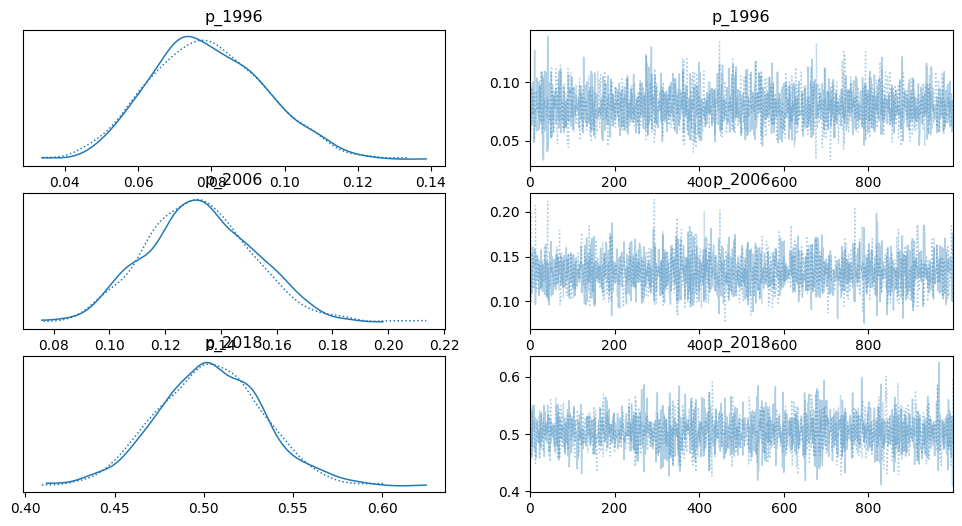

In [ ]:
az.plot_trace(trace_years);

In [ ]:
from IPython.display import display

summary_years = az.summary(trace_years, hdi_prob=0.95)
display(summary_years)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_1996,0.079,0.016,0.050,0.110,0.000,0.0,3037.0,1311.0,1.00
p_2006,0.133,0.020,0.096,0.171,0.000,0.0,3279.0,1627.0,1.00
p_2018,0.504,0.029,0.445,0.560,0.001,0.0,2986.0,1271.0,1.01


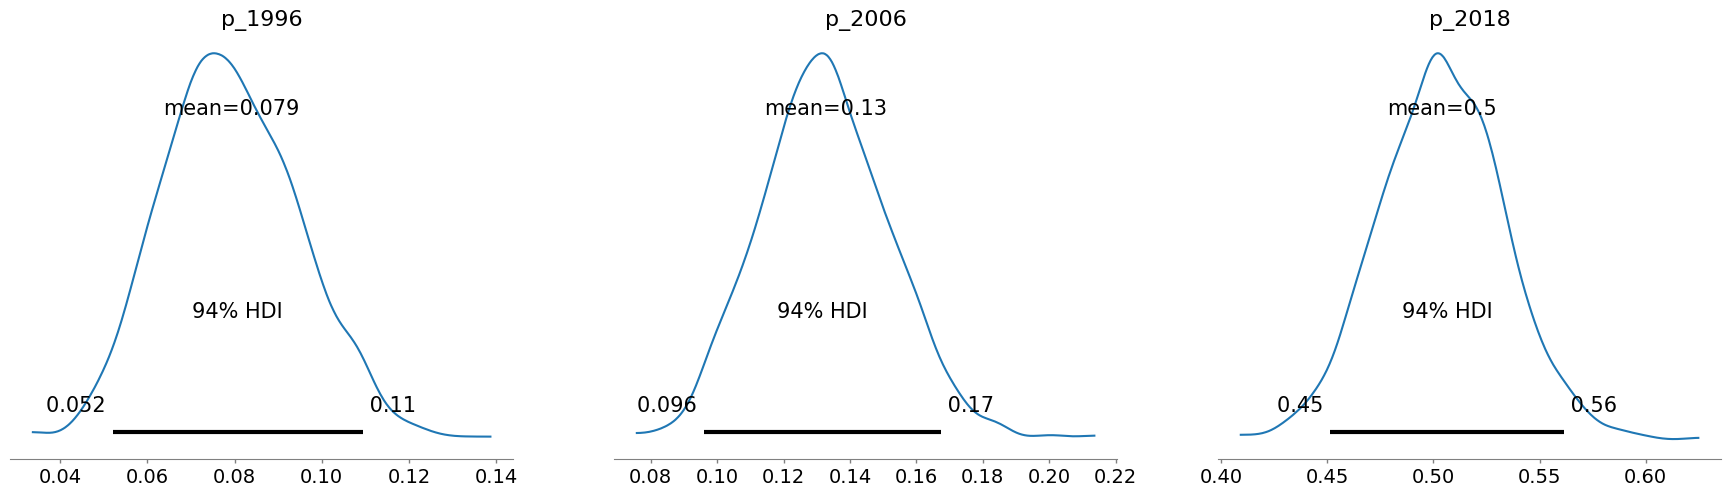

In [ ]:
az.plot_posterior(trace_years);

<u>Conclusions:</u>
- Just like we thought, the probability of scoring more than 220 points has increased over the years, with much bigger increase in the last few 10 years. With the probabilities of 0.079, 0.13, and 0.5 for the years 1996, 2006, and 2018 respectively.
- The "sd", which represents the uncertainty of our estimate, is between 0.016-0.029, which isn't as good as the one for 2019, but still a lot better than the one for 2000 and 2015 (~0.05), Which make sense considering the size of the data.


**The End!**

-----------